In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import torch
#import torchvision
#import Cov_LSTM
#from torch import nn
#from torch import optim
#from torchvision import transforms


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [2]:
dataset = np.load("imgds.npy")
#print(mask.shape)
#plt.imshow(mask[9][18])
dataset = dataset[0:20,:,:,:,:]

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255


# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)
   


# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))


Training Dataset Shapes: (18, 21, 160, 240, 3), (18, 21, 160, 240, 3)
Validation Dataset Shapes: (2, 21, 160, 240, 3), (2, 21, 160, 240, 3)


Displaying frames for example 5.


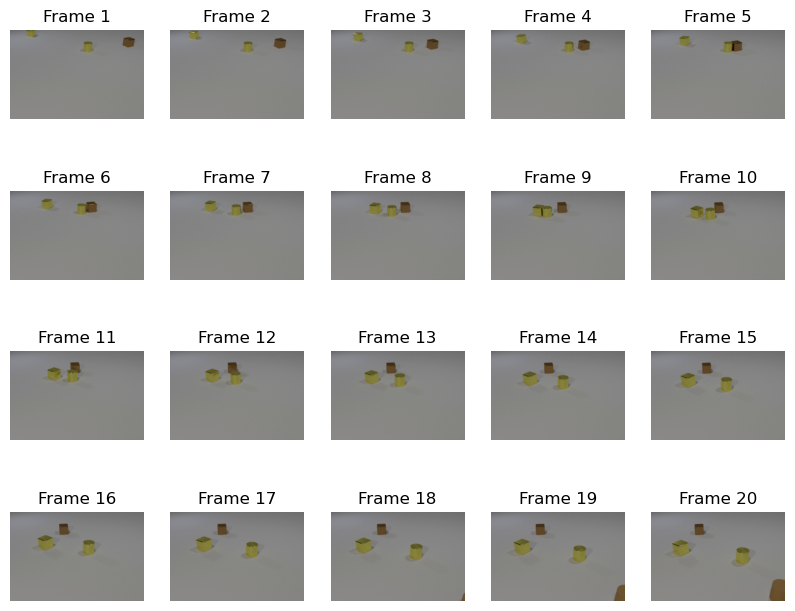

In [3]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [4]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=3, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.legacy.Adam(),
)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [5]:
#Training
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 5
batch_size = 2

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/5


2023-04-25 14:43:18.778385: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


InvalidArgumentError: Graph execution error:

Detected at node 'model/batch_normalization/FusedBatchNormV3' defined at (most recent call last):
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/s1/kj77t2gj5r5d100x59bltw6r0000gn/T/ipykernel_22436/2710493925.py", line 11, in <module>
      model.fit(
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 922, in call
      outputs = self._fused_batch_norm(
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 688, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 662, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model/batch_normalization/FusedBatchNormV3'
Detected at node 'model/batch_normalization/FusedBatchNormV3' defined at (most recent call last):
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/s1/kj77t2gj5r5d100x59bltw6r0000gn/T/ipykernel_22436/2710493925.py", line 11, in <module>
      model.fit(
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 922, in call
      outputs = self._fused_batch_norm(
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 688, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/Users/letaochen/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 662, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model/batch_normalization/FusedBatchNormV3'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  input must be 4-dimensional[2,21,160,240,64]
	 [[{{node model/batch_normalization/FusedBatchNormV3}}]]
	 [[Func/gradient_tape/model/conv_lstm2d_1/while/model/conv_lstm2d_1/while_grad/body/_750/input/_1667/_212]]
  (1) INVALID_ARGUMENT:  input must be 4-dimensional[2,21,160,240,64]
	 [[{{node model/batch_normalization/FusedBatchNormV3}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_6924]

In [ ]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:11, ...]
original_frames = example[11:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()